In [ ]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, arrowhead_marker
from matplotlib.colors import LinearSegmentedColormap
import ipywidgets as widgets
from highlight_text import  ax_text, fig_text
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from adjustText import adjust_text

#Read data
df = pd.read_csv('Footballdata/Season/Ligue1.csv', encoding='latin-1', low_memory = False)

#Temporary because teams are getting combined together
#df['name'] = df['name'].str.cat(df['teamId'], sep='_')

#Adjust to pitch
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

df = df.loc[(df['y'] > 0)]
df = df.loc[(df['y'] < 80)]

#remove
df = df.loc[~(df['type_displayName'] == 'Challenge')]
df = df.loc[~((df['type_displayName'] == 'Aerial') & (df['outcomeType_displayName'] == 'Unsuccessful'))]

#Set passer and receiver
df['passer'] = df['name'].where(df['type_displayName'] == 'Pass', '')
df['recipient'] = df['name'].shift(-1).where(df['type_displayName'] == 'Pass', '')

#Finding previous event to filter out setpieces
df['prevevent'] = df['type_displayName'].shift(1)

#Finding the event before the previous event to filter for Aerials
df['nextevent'] = df['type_displayName'].shift(-1)

#Assist = df[(df['nextevent']=='Goal')]

#Remove passes that come after fouls and cards, potential set pieces
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Foul'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Card'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'CornerAwarded'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'OffsideGiven'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'SubstitutionOn'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'FormationChange'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Start'))]

#main df includes all successful passes
df = df[(df['type_displayName']=='Pass') & (df['outcomeType_displayName']=='Successful')]

In [ ]:
#Penalty Pass
df['pen'] = np.where(((df['endY'].between(16.88,63.12)) & (df['endX']> 99.6)) &
                   (~((df['y'].between(16.88,63.12)) & (df['x']> 99.6))) , 1, 0)

PenPassdf = df.loc[df['pen'] == 1]

#New variables to find progressive passes
df['beginning'] = np.sqrt(np.square(120-df['x']) + np.square(40-df['y']))
df['end'] = np.sqrt(np.square(120-df['endX']) + np.square(40-df['endY']))
df['distance'] = df['beginning'] - df['end']

# At least 30m closer to the opponent’s goal if the starting and finishing points are within a team’s own half
# At least 15m closer to the opponent’s goal if the starting and finishing points are in different halves
# At least 10m closer to the opponent’s goal if the starting and finishing points are in the opponent’s half
df['prog'] = np.where(((df['x']< 60) & (df['endX']< 60) & (df['distance']>=32.80)) |
                      ((df['x']< 60) & (df['endX']>=60) & (df['distance']>=16.40)) |
                      ((df['x']>=60) & (df['endX']>=60) & (df['distance']>=10.94)) |
                       (df['pen'] == 1) & (df['endX'] > df['x']),1,0)

ProgPassdf = df.loc[df['prog'] == 1]

Assist = df[df['nextevent']=='Goal']

#Central Progressive Passes
df['Central_ProgPass'] =  np.where(((df['y'].between(16.88, 63.12)) & (df['x'].between(20.4, 99.6))) &
                                   ((df['endY'].between(16.88, 63.12)) & (df['endX'].between(20.4, 99.6))) &
                                    (df['prog'] == 1),1,0)

CPPassdf = df.loc[df['Central_ProgPass'] == 1]

In [ ]:
#List of Progressive Passes
ProgPass_list = ProgPassdf.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Progressive Passes'}).sort_values('name', ascending = True).reset_index()
del ProgPass_list['index']

PenPass_list = PenPassdf.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Penalty Passes'}).sort_values('name', ascending = True).reset_index()
del PenPass_list['index']

CProgPass_list = CPPassdf.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Central Progressive Passes'}).sort_values('name', ascending = True).reset_index()
del CProgPass_list['index']

#Total List
passlist = pd.merge(pd.merge(ProgPass_list, CProgPass_list, how='outer'), PenPass_list, how='outer')
passlist.fillna(0, inplace=True)
passlist.rename(columns = {'teamId':'Team', 'name':'Player'},inplace = True)
passlist = passlist.sort_values('Penalty Passes', ascending= False).reset_index(drop = True)
passlist.index += 1

passlist["Progressive Passes"] = passlist["Progressive Passes"].astype(int)
passlist["Penalty Passes"] = passlist["Penalty Passes"].astype(int)
passlist["Central Progressive Passes"] = passlist["Central Progressive Passes"].astype(int)

passlist['Player'] = passlist['Player'].str.split('_').str[0]
passlist.head(20)

#passlist.to_csv(r'C:\Users\user\Downloads\Passes\PL.csv', encoding='latin-1')#
passlist.loc[passlist['Player'] == 'Folarin Balogun']

In [ ]:
#List it in a combo box
options = df["name"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
playerlist = widgets.Combobox(
    placeholder='Enter a name',
    options=options,
    description='Player:',
    ensure_option=True,
    disabled=False
)
playerlist

In [6]:
#player selection
player = playerlist.value

#Successful Progressive Passes of player
Successful_Passes = ProgPassdf.loc[(ProgPassdf['name']==player)]
successful = len(Successful_Passes.index)

#Retrieve team name from the passes
team = Successful_Passes['teamId'].unique()
team = team[0]

#Retrieve Opposition team
oppo = df.loc[(df['teamId']!= team)]
oppo = oppo['teamId'].unique()
oppo = oppo[0]

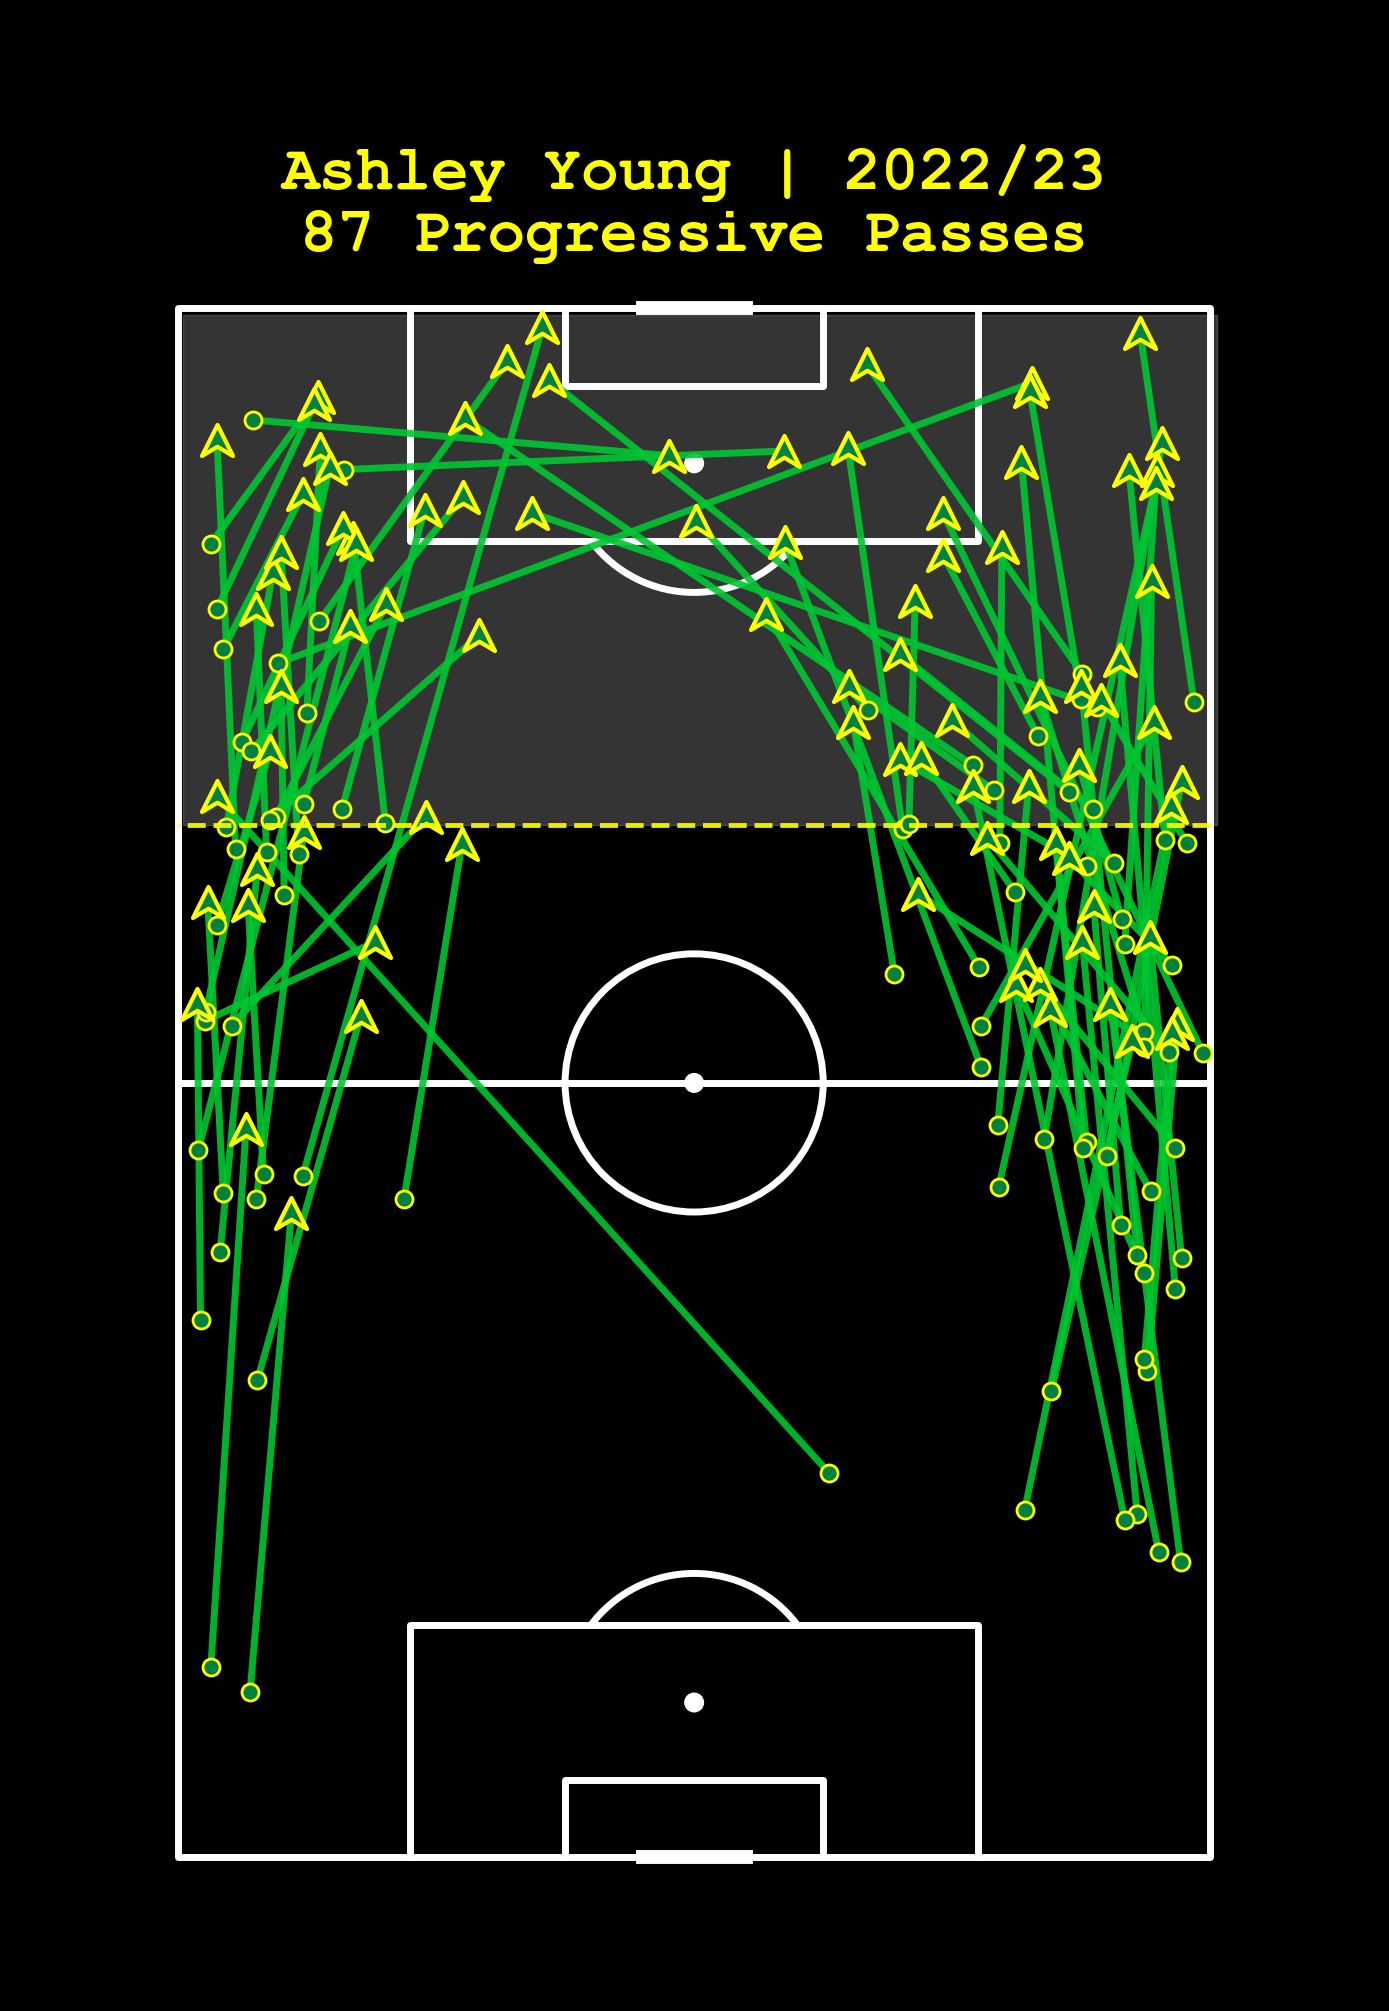

In [7]:
#Set up pitch
pitch = VerticalPitch(pitch_type='statsbomb', 
                  pitch_color='#000000', line_color='white',half = False,
                  line_zorder=1, linewidth=5, spot_scale=0.006)

fig,ax = pitch.draw(figsize=(30, 20), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#000000')

#Inverse the y-axis
plt.gca().invert_xaxis()

#Arrow

#Successful Passes
pitch.scatter(Successful_Passes.x,Successful_Passes.y, edgecolors= 'yellow', c='#008140',
              s = 150, zorder=4, ax=ax, marker = 'o', linewidth=2)

pitch.lines(Successful_Passes.x,Successful_Passes.y,Successful_Passes.endX,Successful_Passes.endY,
            ax=ax, color= '#00c631', lw=5, alpha = 0.9)

pitch.scatter(Successful_Passes.endX,Successful_Passes.endY, edgecolors= 'yellow', c='#008140',marker=arrowhead_marker,
              s = 500, zorder=4, ax=ax, linewidth=3)

#Title
plt.text(40,115,"\n"+player +" | 2022/23\n87 Progressive Passes\n\n",color='yellow', ha='center',
          size=45, fontfamily = "Courier New", fontweight = "bold")

#Draw line
ax.plot([0,80], [80, 80], c='yellow', lw=3.5, ls='--', zorder=9, alpha=0.9)

#shade
plt.axhspan(80,119.5,xmin=0.05,xmax=0.96,color='lightgrey',zorder=-1,alpha=0.25)

#Space
ax.text(45, 142, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')
ax.text(-5, -10, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')
ax.text(93, -10, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')

plt.show()

'\n#Credits\nax.text(0.1, -2, \'By: @chunhang7 | Credit: @mckayjohns\', va=\'center\', ha=\'left\', fontsize=20, color=\'yellow\',\n        fontweight = "bold",fontfamily = "Courier New")\n\nax.text(92, -2, \'vs \'+ oppo, va=\'center\', ha=\'left\', fontsize=20, color=\'yellow\',\n        fontweight = "bold",fontfamily = "Courier New");'

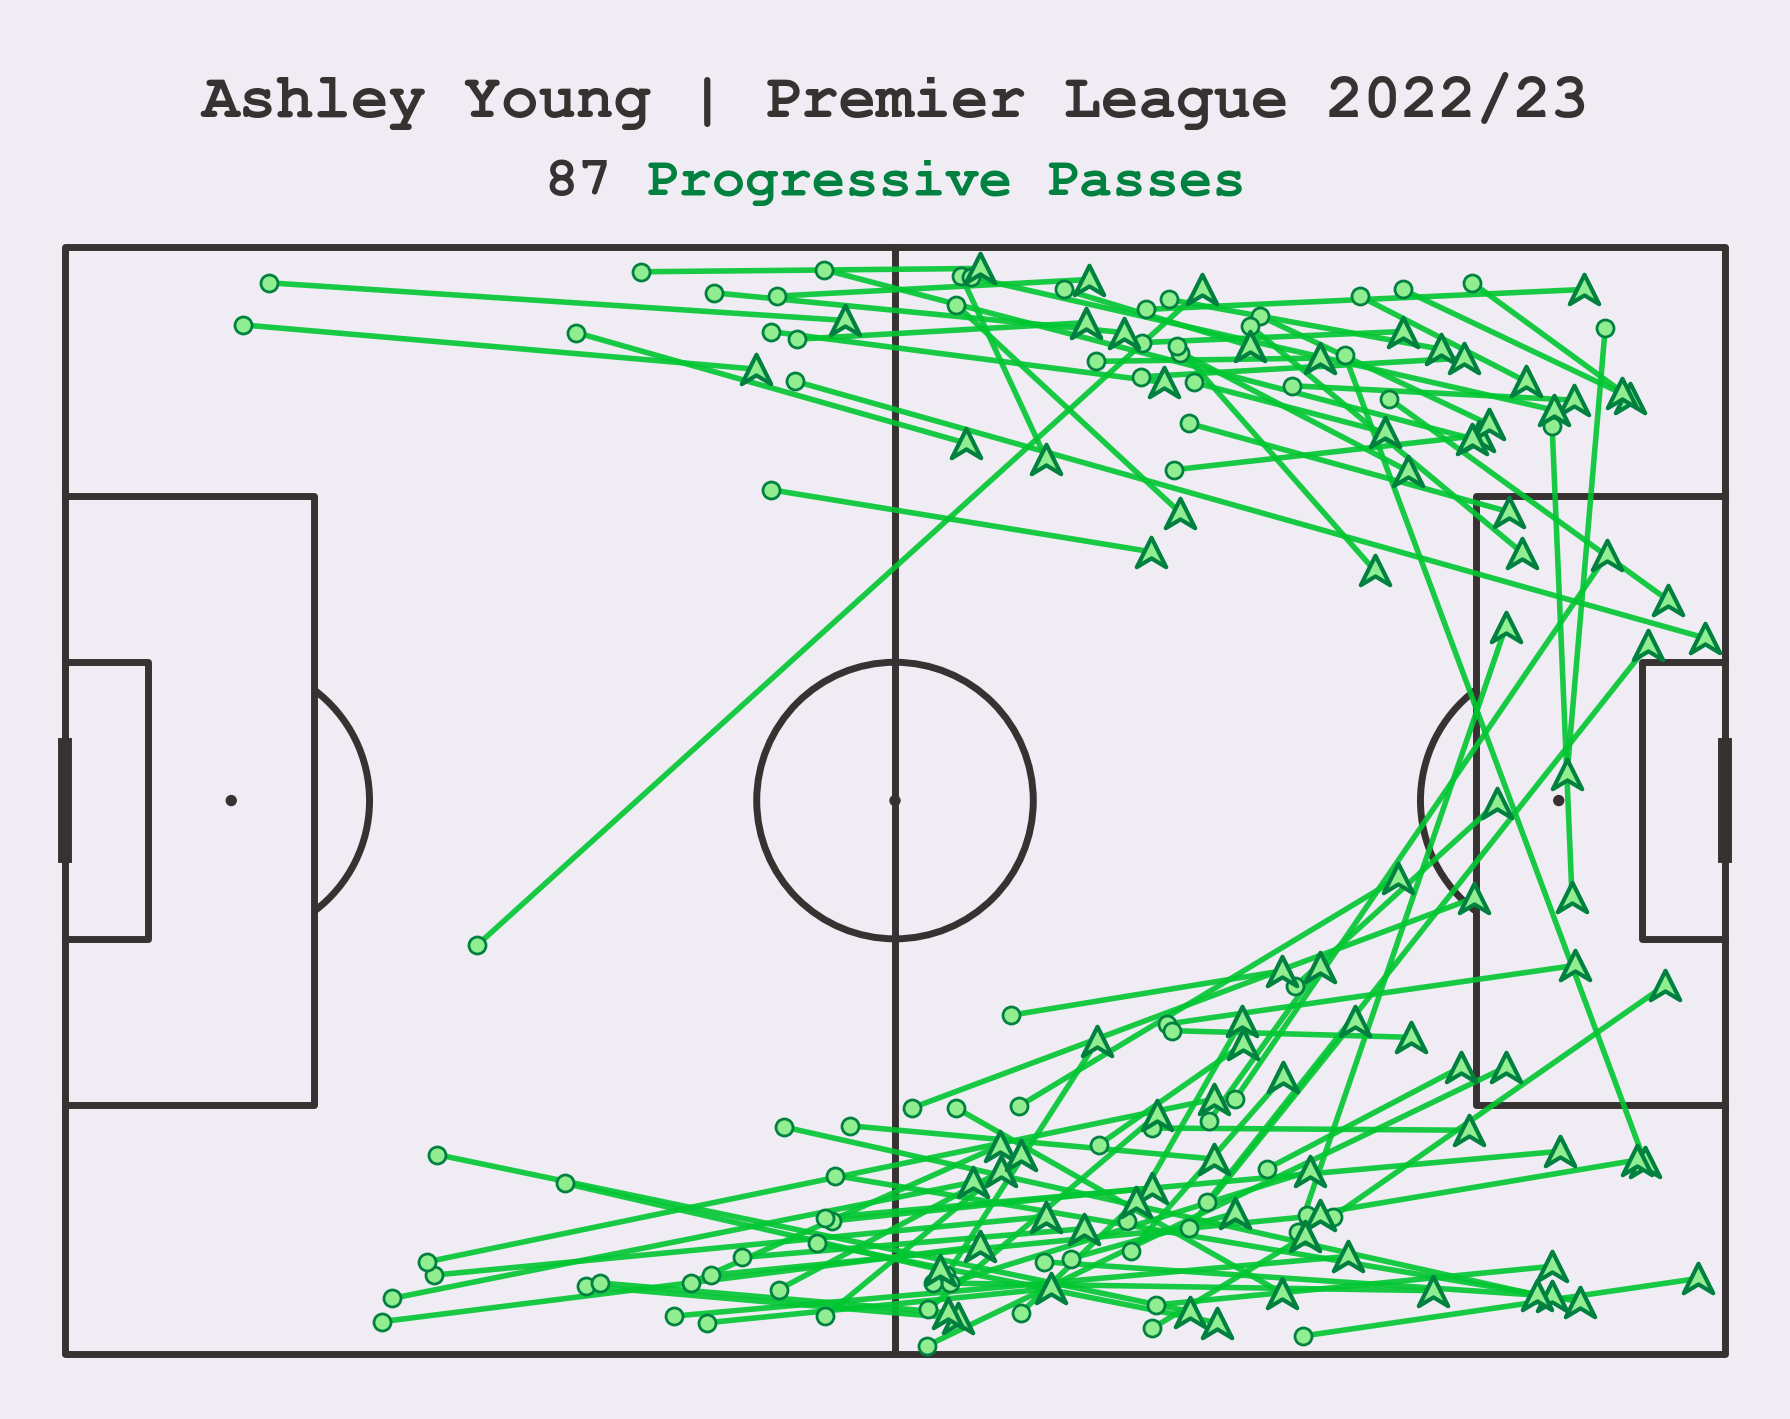

In [14]:
#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#efecf3', line_color='#373231',linewidth=5, spot_scale=0.003)
fig, ax = pitch.draw(figsize=(18, 15), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#efecf3')

#Inverse y-axis
plt.gca().invert_yaxis()

#Successful Passes
pitch.scatter(Successful_Passes.x,Successful_Passes.y, edgecolors= '#008140', c='lightgreen',
              s = 150, zorder=4, ax=ax, marker = 'o', linewidth=2)

pitch.lines(Successful_Passes.x,Successful_Passes.y,Successful_Passes.endX,Successful_Passes.endY,
            ax=ax, color= '#00c631', lw=4, alpha = 0.9)

pitch.scatter(Successful_Passes.endX,Successful_Passes.endY, edgecolors= '#008140', c='lightgreen', marker=arrowhead_marker,
              s = 450, zorder=4, ax=ax, linewidth=3)


#Title & Annotations
fig.suptitle("\n"+player +" | Premier League 2022/23\n", fontsize=45, color='#373231',
            fontfamily = "Courier New", fontweight = "bold",y=0.96)

highlight_textprops =\
    [{"color": "#008140","fontweight": 'bold'}
    ]

Title = fig_text(s = str(successful) + " <Progressive Passes>",
        x = 0.5, y = 0.86, highlight_textprops = highlight_textprops ,color='#373231',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=40);

"""
#Credits
ax.text(0.1, -2, 'By: @chunhang7 | Credit: @mckayjohns', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(92, -2, 'vs '+ oppo, va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New");"""

# Heatmaps

In [21]:
customcmap = LinearSegmentedColormap.from_list('custom cmap', ['#171c38','#fd5901','#db2824','#67000d'])
#ignore warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

#Filter for player, this df is used for the clustering process for all progressive passes
player_progressive_pass = PassAttempts.loc[(PassAttempts['playername']==player)]

#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#171c38', line_color='white',linewidth=9, spot_scale=0.005,line_zorder=1)
fig, ax = pitch.draw(figsize=(15, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#171c38')

#Inverse y-axis
plt.gca().invert_yaxis()

#Set plot boundaries
plt.xlim(0,120)
plt.ylim(0,80)

#Heatmaps of progressive passes origin
kde = sns.kdeplot(player_progressive_pass['x'], player_progressive_pass['y'], shade = True, 
                  shade_lowest= False, n_levels=50, linewidths=3, alpha=1, zorder=0.5, cmap=customcmap)

#Title & Annotations
fig.suptitle("Where does "+ player + "'s Progressive Passes Start?", fontsize=30, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",y=0.95)

#Credits
ax.text(0.1, -2, 'By: @chunhang7', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(92, -2, 'Credit: @mckayjohns', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New");

NameError: name 'PassAttempts' is not defined

In [ ]:
#ignore warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#171c38', line_color='white',linewidth=9, spot_scale=0.005,line_zorder=1)
fig, ax = pitch.draw(figsize=(15, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#171c38')

#Inverse y-axis
plt.gca().invert_yaxis()

#Set plot boundaries
plt.xlim(0,120)
plt.ylim(0,80)


#Heatmap of successful passes destination
kde = sns.kdeplot(Successful_Passes['endX'], Successful_Passes['endY'], shade = True, 
                  shade_lowest= False, n_levels=50, linewidths=3, alpha=1, zorder=0.5, cmap=customcmap)

#Title & Annotations
fig.suptitle("Where does "+ player + "'s Progressive Passes End?", fontsize=30, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",y=0.95)

#Credits
ax.text(0.1, -2, 'By: @chunhang7', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(92, -2, 'Credit: @mckayjohns', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New");

NameError: name 'customcmap' is not defined

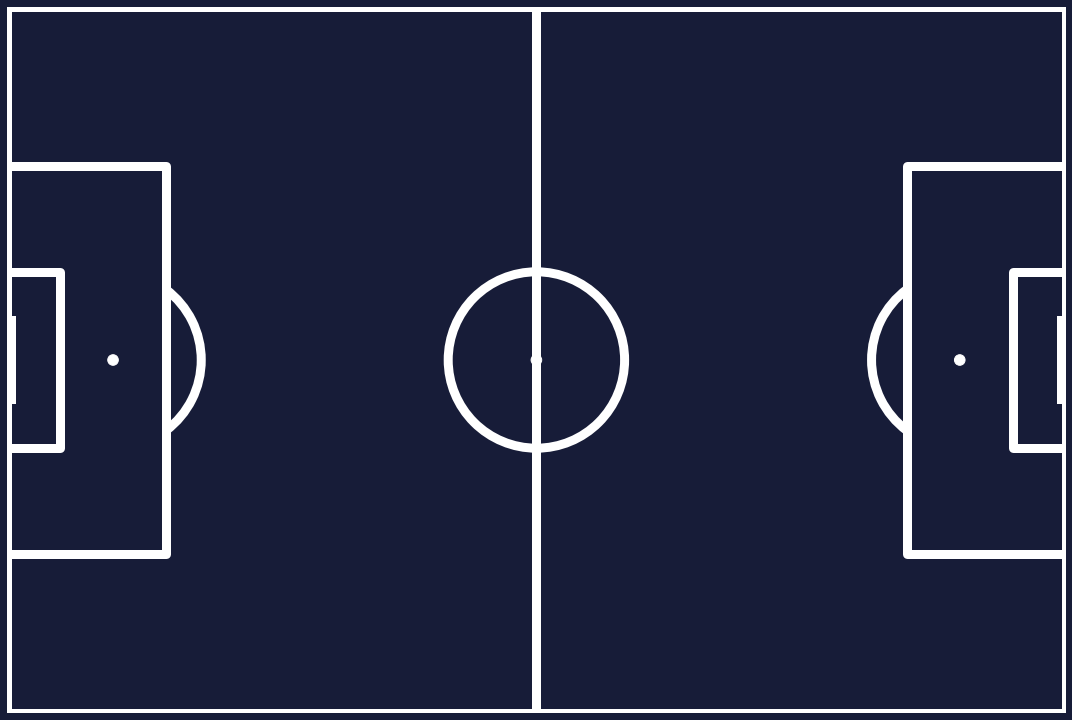

In [7]:
#ignore warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

#Filter for player
Recieve = progressive_pass.loc[(progressive_pass['recipient']==player )]

#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#171c38', line_color='white',linewidth=9, spot_scale=0.005,line_zorder=1)
fig, ax = pitch.draw(figsize=(15, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#171c38')

#Inverse y-axis
plt.gca().invert_yaxis()

#Set plot boundaries
plt.xlim(0,120)
plt.ylim(0,80)

#Heatmap of successful passes destination
kde = sns.kdeplot(Recieve['endX'], Recieve['endY'], shade = True, 
                  shade_lowest= False, n_levels=50, linewidths=3, alpha=1, zorder=0.5, cmap=customcmap)

#Title & Annotations
fig.suptitle("Where does "+ player + "'s Receive Progressive Passes", fontsize=30, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",y=0.95)

#Credits
ax.text(0.1, -2, 'By: @chunhang7', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(92, -2, 'Credit: @mckayjohns', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New");

In [8]:
Received_Passesdf.head(10)

,Unnamed: 0,id,eventId,minute,second,teamId,x,y,expandedMinute,qualifiers,...,prevevent,passer,recipient,teamId_next,beginning,end,distance,25%,prog,pen
1261,1261,2531210333,730,75,7.0,26,44.76,18.56,80,"[{'type': {'value': 212, 'displayName': 'Lengt...",...,Pass,Ibrahima KonatÃ©,Trent Alexander-Arnold,26.0,78.235102,61.324579,16.910523,False,1,0
2007,390,2535263347,289,18,30.0,26,69.84,61.12,18,"[{'type': {'value': 212, 'displayName': 'Lengt...",...,Pass,Virgil van Dijk,Trent Alexander-Arnold,26.0,54.424994,42.082890,12.342105,False,1,0
2321,704,2535272825,490,34,29.0,26,94.56,27.76,34,"[{'type': {'value': 212, 'displayName': 'Lengt...",...,BallRecovery,Mohamed Salah,Trent Alexander-Arnold,26.0,28.231387,17.316258,10.915129,True,0,1
2355,738,2535274259,510,37,22.0,26,67.08,11.28,37,"[{'type': {'value': 56, 'displayName': 'Zone'}...",...,Pass,Ibrahima KonatÃ©,Trent Alexander-Arnold,26.0,60.211002,45.030550,15.180453,True,1,0
3840,450,2537117339,344,30,9.0,26,73.08,18.48,30,"[{'type': {'value': 140, 'displayName': 'PassE...",...,Pass,Jordan Henderson,Trent Alexander-Arnold,26.0,51.619733,38.160776,13.458957,True,1,0
4197,807,2537175819,610,48,28.0,26,2.16,41.20,52,"[{'type': {'value': 1, 'displayName': 'Longbal...",...,Claim,Alisson,Trent Alexander-Arnold,26.0,117.846110,82.028210,35.817900,True,1,0
4224,834,2537178307,627,49,44.0,26,104.64,5.36,53,"[{'type': {'value': 140, 'displayName': 'PassE...",...,Clearance,Mohamed Salah,Trent Alexander-Arnold,26.0,37.892733,21.923248,15.969485,True,1,1
4359,969,2537198773,710,60,7.0,26,64.56,54.56,64,"[{'type': {'value': 178, 'displayName': 'Stand...",...,Pass,Ibrahima KonatÃ©,Trent Alexander-Arnold,26.0,57.320042,44.763503,12.556539,False,1,0
5386,548,2539567815,369,29,14.0,26,61.56,69.28,29,"[{'type': {'value': 56, 'displayName': 'Zone'}...",...,Pass,Andrew Robertson,Trent Alexander-Arnold,26.0,65.364761,53.635093,11.729668,False,1,0
5400,562,2539568235,383,29,52.0,26,66.72,55.92,29,"[{'type': {'value': 178, 'displayName': 'Stand...",...,Pass,Virgil van Dijk,Trent Alexander-Arnold,26.0,55.607597,41.577783,14.029814,True,1,0


In [9]:
#Adjust to pitch
Received_Passesdf['x'] = Received_Passesdf['x']/1.2
Received_Passesdf['y'] = Received_Passesdf['y']/.8
Received_Passesdf['endX'] = Received_Passesdf['endX']/1.2
Received_Passesdf['endY'] = Received_Passesdf['endY']/.8

C:\Users\user\AppData\Local\Temp/ipykernel_14956/2160467999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Received_Passesdf['x'] = Received_Passesdf['x']/1.2
C:\Users\user\AppData\Local\Temp/ipykernel_14956/2160467999.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Received_Passesdf['y'] = Received_Passesdf['y']/.8
C:\Users\user\AppData\Local\Temp/ipykernel_14956/2160467999.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [10]:
Received_Passesdf.head(10)

,Unnamed: 0,id,eventId,minute,second,teamId,x,y,expandedMinute,qualifiers,...,prevevent,passer,recipient,teamId_next,beginning,end,distance,25%,prog,pen
1261,1261,2531210333,730,75,7.0,26,37.3,23.2,80,"[{'type': {'value': 212, 'displayName': 'Lengt...",...,Pass,Ibrahima KonatÃ©,Trent Alexander-Arnold,26.0,78.235102,61.324579,16.910523,False,1,0
2007,390,2535263347,289,18,30.0,26,58.2,76.4,18,"[{'type': {'value': 212, 'displayName': 'Lengt...",...,Pass,Virgil van Dijk,Trent Alexander-Arnold,26.0,54.424994,42.082890,12.342105,False,1,0
2321,704,2535272825,490,34,29.0,26,78.8,34.7,34,"[{'type': {'value': 212, 'displayName': 'Lengt...",...,BallRecovery,Mohamed Salah,Trent Alexander-Arnold,26.0,28.231387,17.316258,10.915129,True,0,1
2355,738,2535274259,510,37,22.0,26,55.9,14.1,37,"[{'type': {'value': 56, 'displayName': 'Zone'}...",...,Pass,Ibrahima KonatÃ©,Trent Alexander-Arnold,26.0,60.211002,45.030550,15.180453,True,1,0
3840,450,2537117339,344,30,9.0,26,60.9,23.1,30,"[{'type': {'value': 140, 'displayName': 'PassE...",...,Pass,Jordan Henderson,Trent Alexander-Arnold,26.0,51.619733,38.160776,13.458957,True,1,0
4197,807,2537175819,610,48,28.0,26,1.8,51.5,52,"[{'type': {'value': 1, 'displayName': 'Longbal...",...,Claim,Alisson,Trent Alexander-Arnold,26.0,117.846110,82.028210,35.817900,True,1,0
4224,834,2537178307,627,49,44.0,26,87.2,6.7,53,"[{'type': {'value': 140, 'displayName': 'PassE...",...,Clearance,Mohamed Salah,Trent Alexander-Arnold,26.0,37.892733,21.923248,15.969485,True,1,1
4359,969,2537198773,710,60,7.0,26,53.8,68.2,64,"[{'type': {'value': 178, 'displayName': 'Stand...",...,Pass,Ibrahima KonatÃ©,Trent Alexander-Arnold,26.0,57.320042,44.763503,12.556539,False,1,0
5386,548,2539567815,369,29,14.0,26,51.3,86.6,29,"[{'type': {'value': 56, 'displayName': 'Zone'}...",...,Pass,Andrew Robertson,Trent Alexander-Arnold,26.0,65.364761,53.635093,11.729668,False,1,0
5400,562,2539568235,383,29,52.0,26,55.6,69.9,29,"[{'type': {'value': 178, 'displayName': 'Stand...",...,Pass,Virgil van Dijk,Trent Alexander-Arnold,26.0,55.607597,41.577783,14.029814,True,1,0


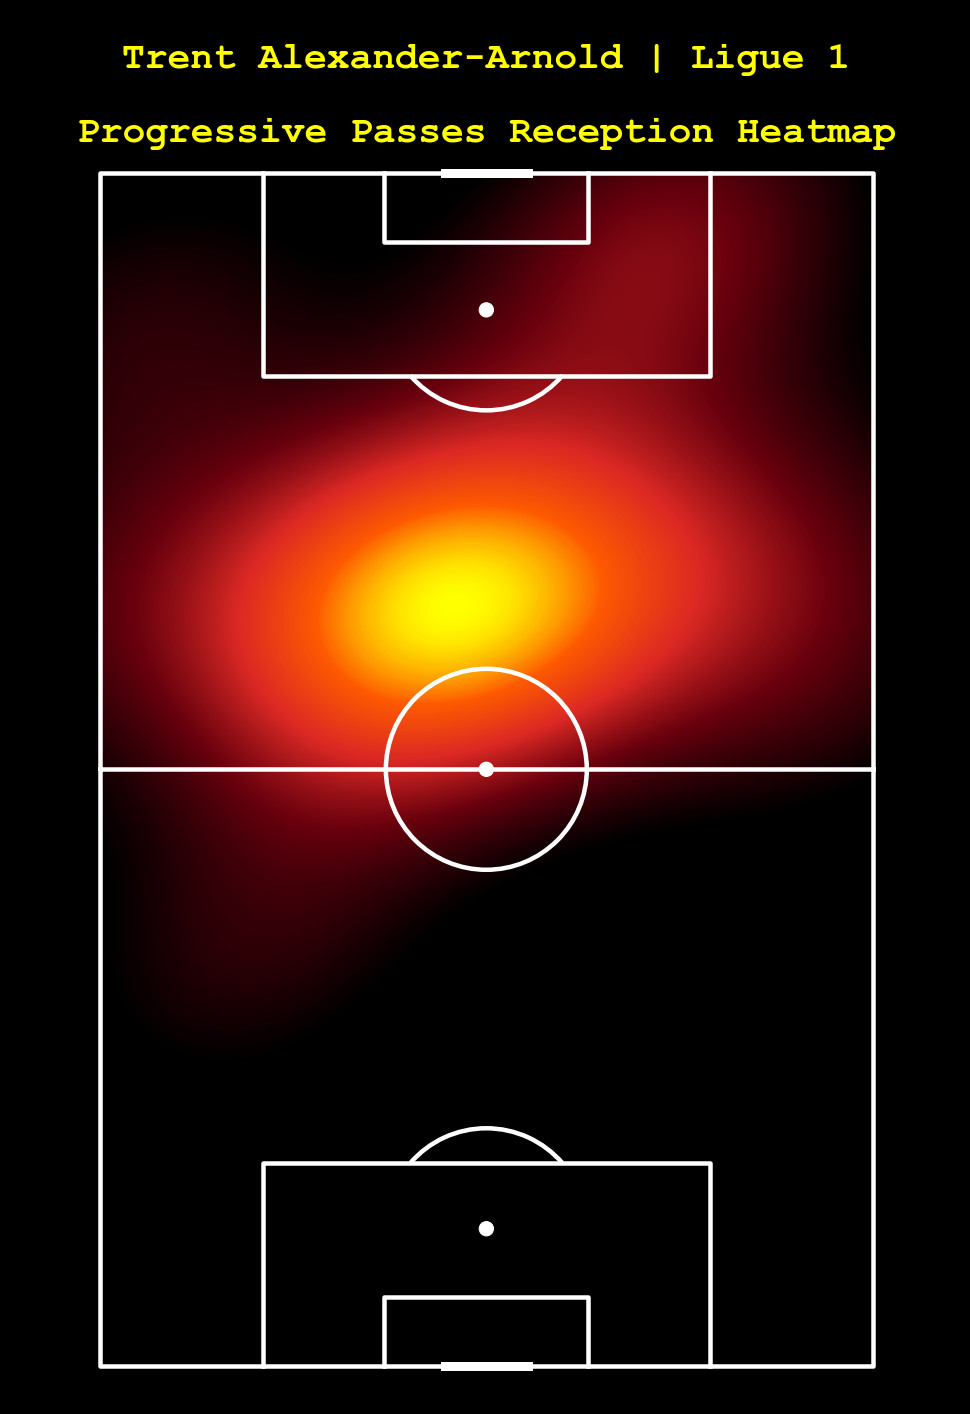

In [11]:
"""#Adjust to pitch
Received_Passesdf['x'] = Received_Passesdf['x']/1.2
Received_Passesdf['y'] = Received_Passesdf['y']/.8
Received_Passesdf['endX'] = Received_Passesdf['endX']/1.2
Received_Passesdf['endY'] = Received_Passesdf['endY']/.8
"""
#ignore warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

#Set Color
customcmap = LinearSegmentedColormap.from_list('custom cmap', ['#000000','#67000d','#db2824','#fd5901','yellow'])

pitch = VerticalPitch(pitch_type='opta', pitch_color='#000000', line_color='white',half = False,
                  line_zorder=1, linewidth=4.5, spot_scale=0.006)

fig,ax = pitch.draw(figsize=(30, 20), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#000000')

kde = pitch.kdeplot(Received_Passesdf.endX, Received_Passesdf.endY, statistic='count', ax=ax, cmap=customcmap, shade=True, 
                    shade_lowest=False, n_levels=400, linewidths=3, alpha=1, zorder=0.99)

#Title & Annotations
fig.suptitle("\n"+player+" | Ligue 1\n\nProgressive Passes Reception Heatmap", fontsize=38, color='yellow',
            fontfamily = "Courier New", fontweight = "bold", y=0.98)

ax.text(112, -2.5, 'space', va='center', ha='left', fontsize=25, color='black',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(-2, -2.5, 'space', va='center', ha='left', fontsize=25, color='black',
        fontweight = "bold",fontfamily = "Courier New")

plt.show()

# Vertical Pitch

#Make the Vertical pitch
pitch = VerticalPitch(pitch_type='statsbomb', 
                  pitch_color='#c21821', line_color='white',half = False,
                  line_zorder=1, linewidth=4.5, spot_scale=0.006)

fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#c21821')

#inverse y-axis
plt.gca().invert_xaxis()


#Plot Successful Passes
pitch.lines(Successful_Passes.x,Successful_Passes.y,Successful_Passes.endX,Successful_Passes.endY,
            comet=True,ax=ax, linewidth=12, capstyle='round', 
            alpha=0.6, color ='lightgreen')

pitch.scatter(Successful_Passes['endX'], Successful_Passes['endY'],
              edgecolors= "lightgreen", c="w", s = 250, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5, label='Successful Passes')

#Plot Unsuccessful Passes
pitch.lines(Unsuccessful_Passes.x,Unsuccessful_Passes.y,Unsuccessful_Passes.endX,Unsuccessful_Passes.endY,
            comet=True,ax=ax, linewidth=12, 
            alpha=0.6, color ='black')

pitch.scatter(Unsuccessful_Passes['endX'], Unsuccessful_Passes['endY'],
              edgecolors= "black", c="yellow", s = 250, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5, label='Unsuccessful Passes')

# Clustering

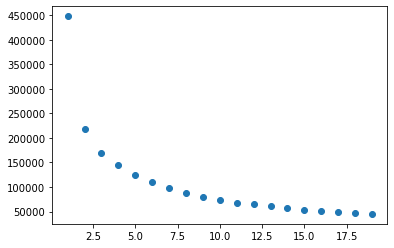

In [10]:
#Use either player_progressive_pass or Successful_Passes dataframe

# Elbow Method: determining how many clusters to use in the final plots
K = range(1,20)
wss= []
for k in K:
    array = np.array(player_progressive_pass[['x', 'y', 'endX', 'endY','passlength']])
    kmeans = KMeans(n_clusters = k, random_state = 100)
    kmeans.fit(array)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)
    
mycenters = pd.DataFrame({'Clusters':K, 'WSS':wss})
mycenters
# Reading the results of the Elbow Method: imagine the shape created
# by this scatter plot as one of an arm. The part best-resembling an elbow
# is considered the "ideal" amount of clusters to use
plt.scatter(x=mycenters['Clusters'], y=mycenters['WSS'])

In [11]:
#Remove warning
pd.options.mode.chained_assignment = None 

# Clustering the passes. Note that n_clusters = the result from the scatter
# plot above and is inputted manually
array = np.array(player_progressive_pass[['x', 'y', 'endX', 'endY','passlength']])
kmeans = KMeans(n_clusters = 10, random_state = 100)
kmeans.fit(array)
player_progressive_pass['cluster'] = kmeans.predict(array)

# Creates list to index most frequent clusters
art = player_progressive_pass.cluster.value_counts().index.tolist()[0:3]

# Filtering for clusters
cluster1 = player_progressive_pass[player_progressive_pass['cluster'] == art[0]]
cluster2 = player_progressive_pass[player_progressive_pass['cluster'] == art[1]]
cluster3 = player_progressive_pass[player_progressive_pass['cluster'] == art[2]]

In [12]:
#Find Average location of the passes 
cluster1avg = cluster1.groupby('playername').agg({'x': ['median'], 'y': ['mean'], 'endX': ['mean'], 'endY': ['mean']})
cluster1avg.columns = ['x', 'y', 'endX','endY']

cluster2avg = cluster2.groupby('playername').agg({'x': ['mean'], 'y': ['mean'], 'endX': ['mean'], 'endY': ['mean']})
cluster2avg.columns = ['x', 'y', 'endX','endY']

cluster3avg = cluster3.groupby('playername').agg({'x': ['mean'], 'y': ['mean'], 'endX': ['mean'], 'endY': ['mean']})
cluster3avg.columns = ['x', 'y', 'endX','endY']

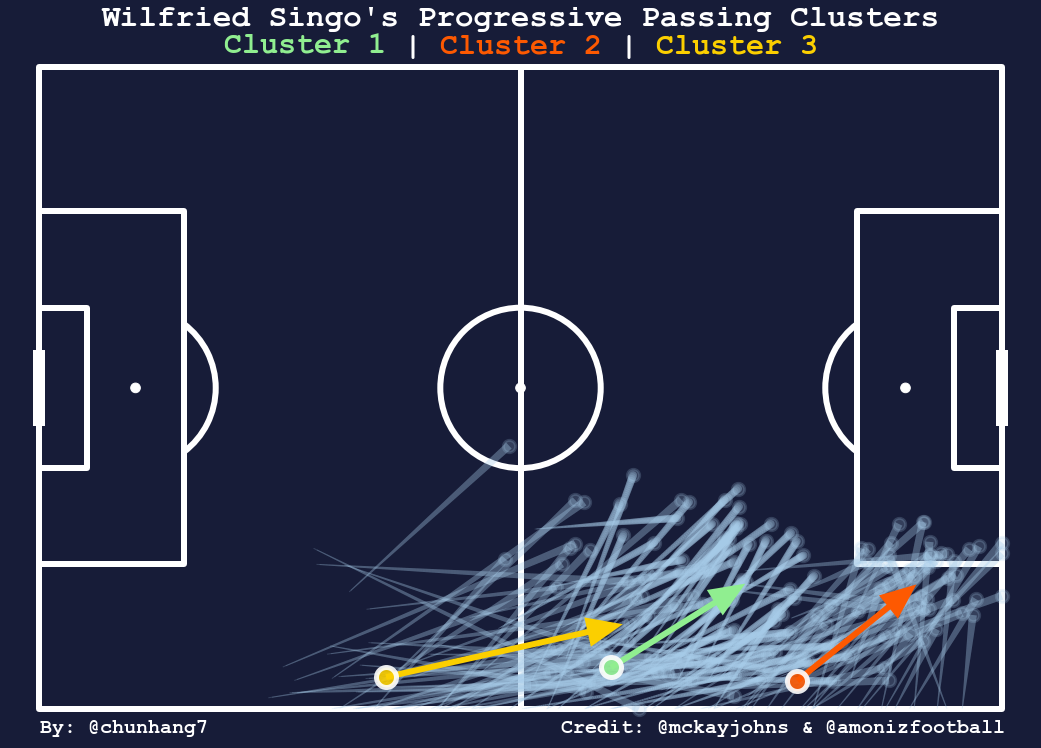

In [18]:
#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#171c38', line_color='white',linewidth=6, spot_scale=0.005)
fig, ax = pitch.draw(figsize=(15, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#171c38')

#Inverse y-axis
plt.gca().invert_yaxis()

#Plot cluster1
pitch.lines(cluster1.x,cluster1.y,cluster1.endX,cluster1.endY,
            comet=True,ax=ax, linewidth=8, capstyle='round', zorder=2,
            alpha=0.2, color ='#aacfec')

pitch.scatter(cluster1['endX'], cluster1['endY'],
              edgecolors= "#aacfec", c="#aacfec", s = 150, zorder=2, ax=ax, 
              marker = 'o', alpha = 0.2,linewidths=3)

#Plot cluster2
pitch.lines(cluster2.x,cluster2.y,cluster2.endX,cluster2.endY,
            comet=True,ax=ax, linewidth=8, zorder=2,
            alpha=0.2, color ='#aacfec')

pitch.scatter(cluster2['endX'], cluster2['endY'],
              edgecolors= "#aacfec", c="#aacfec", s = 150, zorder=2, ax=ax, 
              marker = 'o', alpha = 0.2,linewidths=3)

#Plot cluster3
pitch.lines(cluster3.x,cluster3.y,cluster3.endX,cluster3.endY,
            comet=True,ax=ax, linewidth=8, zorder=2,
            alpha=0.2, color ='#aacfec')

pitch.scatter(cluster3['endX'], cluster3['endY'],
              edgecolors= "#aacfec", c="#aacfec", s = 150, zorder=2, ax=ax, 
              marker = 'o', alpha = 0.2,linewidths=3)


#Plot cluster1
pitch.arrows(cluster1avg.x,cluster1avg.y,cluster1avg.endX,cluster1avg.endY,zorder=4,
             ax=ax, width=6, headwidth=5, headlength=6, headaxislength=6,color ='lightgreen')

pitch.scatter(cluster1avg['x'], cluster1avg['y'],
              edgecolors= "w", c="lightgreen", s = 400, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5)

#Plot cluster2
pitch.arrows(cluster2avg.x,cluster2avg.y,cluster2avg.endX,cluster2avg.endY,zorder=4,
             ax=ax, width=6, headwidth=5, headlength=6, headaxislength=6,color ='#fd5901')

pitch.scatter(cluster2avg['x'], cluster2avg['y'],
              edgecolors= "w", c="#fd5901", s = 400, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5)

#Plot cluster3
pitch.arrows(cluster3avg.x,cluster3avg.y,cluster3avg.endX,cluster3avg.endY,zorder=4,
             ax=ax, width=6, headwidth=5, headlength=6, headaxislength=6,color ='#fbcf00')

pitch.scatter(cluster3avg['x'], cluster3avg['y'],
              edgecolors= "w", c="#fbcf00", s = 400, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5)


#Title & Annotations
fig.suptitle(player +"'s Progressive Passing Clusters\n", fontsize=31, color='w',
            fontfamily = "Courier New", fontweight = "bold",y=0.94)

highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'},
     {"color": "#fd5901","fontweight": 'bold'},
     {"color": "#fbcf00","fontweight": 'bold'}
    ]

Title = fig_text(s = "<Cluster 1> | <Cluster 2> | <Cluster 3>" ,
        x = 0.5, y = 0.905, highlight_textprops = highlight_textprops ,color='white',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=30);

#Credits
ax.text(0.1, -2.5, 'By: @chunhang7', va='center', ha='left', fontsize=20, color='w',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(65, -2.5, 'Credit: @mckayjohns & @amonizfootball', va='center', ha='left', fontsize=20, color='w',
        fontweight = "bold",fontfamily = "Courier New");

Text(66, -2, 'Credit: @mckayjohns & @amonizfootball')

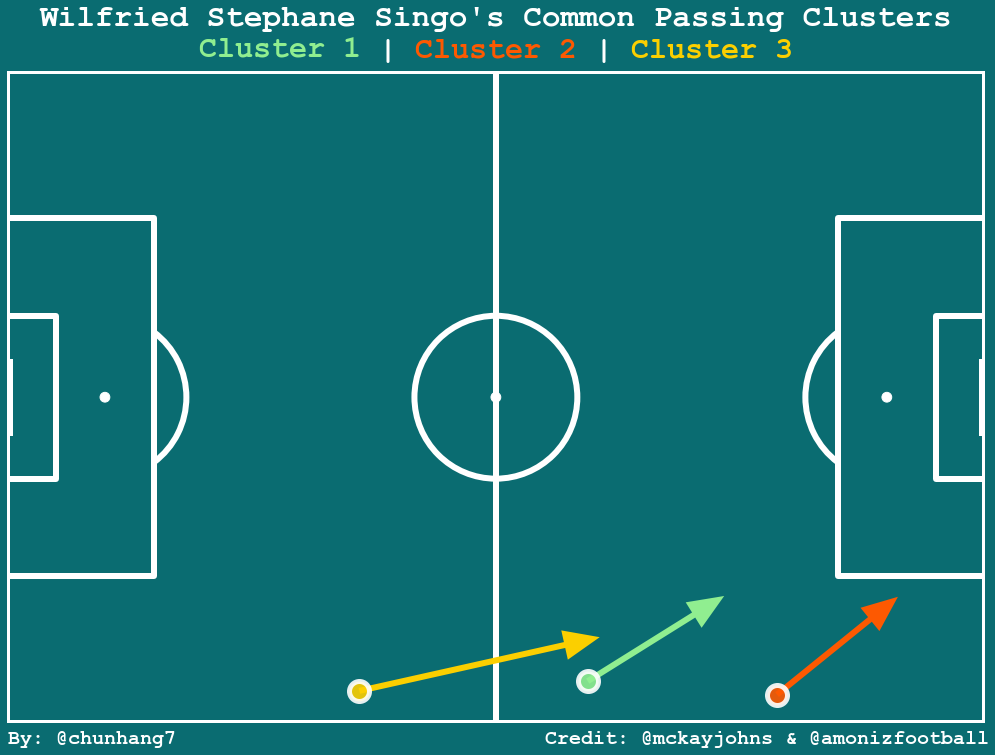

In [15]:
#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#0a6c71', line_color='white',linewidth=6, spot_scale=0.005)
fig, ax = pitch.draw(figsize=(15, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#0a6c71')

#Inverse y-axis
plt.gca().invert_yaxis()

#Set plot boundaries
plt.xlim(0,120)
plt.ylim(0,80)

#Plot cluster1
pitch.arrows(cluster1avg.x,cluster1avg.y,cluster1avg.endX,cluster1avg.endY
            ,ax=ax, width=6, headwidth=5, headlength=6, headaxislength=6,color ='lightgreen')

pitch.scatter(cluster1avg['x'], cluster1avg['y'],
              edgecolors= "w", c="lightgreen", s = 400, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5)

#Plot cluster2
pitch.arrows(cluster2avg.x,cluster2avg.y,cluster2avg.endX,cluster2avg.endY
            ,ax=ax, width=6, headwidth=5, headlength=6, headaxislength=6,color ='#fd5901')

pitch.scatter(cluster2avg['x'], cluster2avg['y'],
              edgecolors= "w", c="#fd5901", s = 400, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5)

#Plot cluster2
pitch.arrows(cluster3avg.x,cluster3avg.y,cluster3avg.endX,cluster3avg.endY
            ,ax=ax, width=6, headwidth=5, headlength=6, headaxislength=6,color ='#fbcf00')

pitch.scatter(cluster3avg['x'], cluster3avg['y'],
              edgecolors= "w", c="#fbcf00", s = 400, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5)


#Title & Annotations
fig.suptitle(player +"'s Common Passing Clusters\n\n", fontsize=31, color='w',
            fontfamily = "Courier New", fontweight = "bold",y=0.95)

highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'},
     {"color": "#fd5901","fontweight": 'bold'},
     {"color": "#fbcf00","fontweight": 'bold'}
    ]

Title = fig_text(s = "<Cluster 1> | <Cluster 2> | <Cluster 3>" ,
        x = 0.5, y = 0.91, highlight_textprops = highlight_textprops ,color='white',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=30);

#Credits
ax.text(0.1, -2, 'By: @chunhang7', va='center', ha='left', fontsize=20, color='w',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(66, -2, 'Credit: @mckayjohns & @amonizfootball', va='center', ha='left', fontsize=20, color='w',
        fontweight = "bold",fontfamily = "Courier New")

KeyboardInterrupt: 

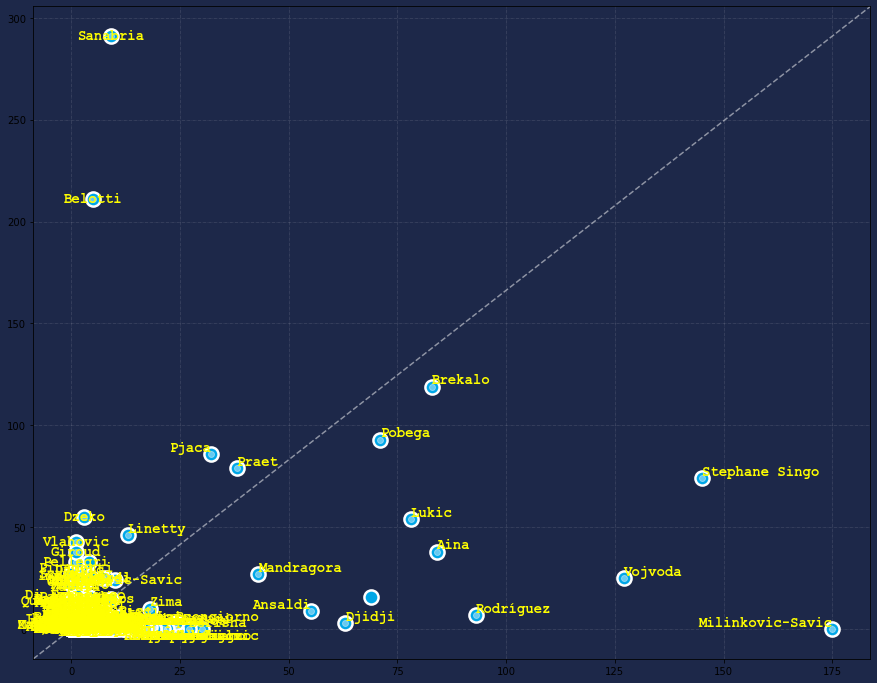

In [16]:
#Remove warning
pd.options.mode.chained_assignment = None

#Taking the variables that are needed
result = result[['Player','Successful Passes','Received Passes']]

#Setting up quartiles
q1_SP = result['Successful Passes'].quantile(0.2)
q2_SP = result['Successful Passes'].quantile(0.5)
q3_SP = result['Successful Passes'].quantile(0.9)

q1_RP = result['Received Passes'].quantile(0.2)
q2_RP = result['Received Passes'].quantile(0.5)
q3_RP = result['Received Passes'].quantile(0.9)

#result.head()

# Figure Size 
fig, ax = plt.subplots(figsize=(15,12))
fig.set_facecolor('#1d2849')

# Grid
ax.grid(color='white', linestyle='-.', linewidth=0.5, alpha=0.2)
ax.set_facecolor('#1d2849')
#ax.axhline(q2_RP, c='w', alpha=0.5, ls='--')
#ax.axvline(q2_SP, c='w', alpha=0.5, ls='--')

ax.plot([0, 1], [0, 1], transform=ax.transAxes, c='w', alpha=0.5, ls='--')


x, y = result['Successful Passes'].tolist(), result['Received Passes'].tolist()
ax.scatter(x, y, c='#00a7e7',edgecolor='w', lw =2.5, s = 200)

#Setting labels
texts = []
for x, y, s in zip(result['Successful Passes'].tolist(), result['Received Passes'], result['Player']):
    if len(s.split())==1:
        name = s
    else:
        name = ' '.join(s.split()[1:])
        ax.scatter(x, y, c='w', alpha = 0.4)
        texts.append(ax.text(x, y, name, fontdict=dict(color='yellow', size=14,fontfamily='Courier New',fontweight='bold')))
        
adjust_text(texts,force_points=0.2, force_text=0.2,
             expand_points=(1.5,1.5), expand_text=(1.5,1.5),
             arrowprops=dict(arrowstyle = '-', lw=2.5, color='yellow'))

#Setting Title
fig.text(0.23,0.93,'Progressive Passes Received & Distributed'.upper(),size = 25, color='w',weight='heavy',fontfamily='Courier New')
fig.text(0.37,0.90,team + " vs " + oppo, size = 20,fontfamily='Courier New',fontweight='bold',color='w')

#Labels
ax.set_ylabel('Progressive Passes Received', size=18, weight='bold',color='w',fontfamily='Courier New')
ax.set_xlabel('Progressive Passes Made',fontweight='bold', size=18,color='w',fontfamily='Courier New')

# Remove axes spines
for s in ['right','top']:
    ax.spines[s].set_visible(False)

#Set spine width & color
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

# Remove x,y Ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=10, width=5,length=5,direction='in',colors='w')
ax.yaxis.set_tick_params(pad=10, width=5,length=5,direction='in',colors='w')

#Captions
ax.text(4.5,9,'Main\nOutlets', c='w', size=20,va='center',ha='center',fontfamily='Courier New',fontweight='bold')
ax.text(7,4,'Main\nProgressors', c='w', size=20,va='center',ha='center',fontfamily='Courier New',fontweight='bold')

#Watermark
fig.text(0.85, 0.082, "By @chunhang7", fontsize=14, color='#f5f201',ha='right', va='bottom', 
         alpha=0.4, fontweight='bold', fontfamily='Courier New');